<a href="https://colab.research.google.com/github/lara-sj/cots-detection-model/blob/main/GBR_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Help Protect the Great Barrier Reef

## Introduction 
The Great Barrier Reef is under threat due to the overpopulation of the Crown-of-Thorns Starfish (COTS). AI technology could drastically improve the efficiency and scale at which reef managers detect and control COTS outbreaks.

Australia's national science agency, CSIRO, has teamed up with Google to develop innovative machine learning technology that can analyse large image datasets efficiently.

This project is part of a Kaggle challenge sponsored by Tensorflow.

## Objective
The goal of this project is to:
* predict the presence and position COTS in underwater images. The images were taken at various times and locations around the Great Barrier Reef.
* the predictions take the form of a bounding box together with a confidence score for each identified COTS 

## Metadata

The data was downloaded from this [Kaggle challenge](https://www.kaggle.com/c/tensorflow-great-barrier-reef/data).

**train/** - Folder containing training set photos of the form **video_{video_id}/{video_frame_number}.jpg**.

**[train/test].csv** - Metadata for the images. As with other test files, most of the test metadata data is only available to your notebook upon submission. Just the first few rows available for download.

* `video_id` - ID number of the video the image was part of. The video ids are not meaningfully ordered.
* `video_frame` - The frame number of the image within the video. Expect to see occasional gaps in the frame number from when the diver surfaced.
* `sequence` - ID of a gap-free subset of a given video. The sequence ids are not meaningfully ordered.
sequence_frame - The frame number within a given sequence.
* `image_id` - ID code for the image, in the format '{video_id}-{video_frame}'
* `annotations` - The bounding boxes of any starfish detections in a string format that can be evaluated directly with Python. Does not use the same format as the predictions you will submit. Not available in test.csv. A bounding box is described by the pixel coordinate (x_min, y_min) of its upper left corner within the image together with its width and height in pixels.


## 1. Setup & Install Requirements

###1.1 Import Python packages

In [ ]:
import os 
import cv2
import ast
import glob
import torch
import importlib
import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

import shutil
import sys
#sys.path.append('../input/tensortflow-great-barrier-reef')

from PIL import Image
from IPython.display import display


### 1.2 Mount our personal drive

In order to use the dataset on Google Drive, we will mount our drive using the below code:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###1.3 Create directories to save data

In [ ]:
ROOT_DIR  = '/content/drive/MyDrive/great_barrier_reef'
IMAGE_DIR = '/content/drive/MyDrive/great_barrier_reef/data/images/train_images' # directory to save images
LABEL_DIR = '/content/drive/MyDrive/great_barrier_reef/data/labels' # directory to save labels

In [ ]:
!ls {ROOT_DIR}

data  train  valid  yolov5


## 2. Prepare Dataset for YOLOV5


### 2.1 Load in dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/great_barrier_reef/data/labels/train.csv')
df.head()

video_id  sequence  video_frame  sequence_frame image_id annotations
0         0     40258            0               0      0-0          []
1         0     40258            1               1      0-1          []
2         0     40258            2               2      0-2          []
3         0     40258            3               3      0-3          []
4         0     40258            4               4      0-4          []

### 2.2 Store `image_path`, `label_path` and `annotations` into dataframe

In [ ]:
df['image_path'] = f'{IMAGE_DIR}/video_'+df.video_id.astype(str)+'/'+df.video_frame.astype(str)+'.jpg'
df['label_path']  = f'{LABEL_DIR}/'+df.image_id+'.txt'
df['annotations'] = df['annotations'].progress_apply(eval)
display(df.head())
print(df['image_path'][0])

  0%|          | 0/23501 [00:00<?, ?it/s]

video_id  ...                                         label_path
0         0  ...  /content/drive/MyDrive/great_barrier_reef/data...
1         0  ...  /content/drive/MyDrive/great_barrier_reef/data...
2         0  ...  /content/drive/MyDrive/great_barrier_reef/data...
3         0  ...  /content/drive/MyDrive/great_barrier_reef/data...
4         0  ...  /content/drive/MyDrive/great_barrier_reef/data...

[5 rows x 8 columns]

/content/drive/MyDrive/great_barrier_reef/data/images/train_images/video_0/0.jpg


### 2.3 Find number of images with bounding boxes (BBox)
As we can see below, almost 80% of the images in the dataset do not have any bounding boxes.

In [ ]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f'No. of Images without Bounding Boxes: {data[0]:0.2f}%')
print(f'No. of Images WITH at least one Bounding Box: {data[1]:0.2f}%')

  0%|          | 0/23501 [00:00<?, ?it/s]

No. of Images without Bounding Boxes: 79.07%
No. of Images WITH at least one Bounding Box: 20.93%


### 2.4 Remove images without bounding boxes (BBox)
We will only take the images with bounding boxes for training and store this in a new dataframe, `df_train`.

In [ ]:
df_train = df[df['num_bbox']>0]
df_train.shape

(4919, 9)

In [ ]:
df_train.head()

video_id  ...  num_bbox
16         0  ...         1
17         0  ...         1
18         0  ...         1
19         0  ...         1
20         0  ...         1

[5 rows x 9 columns]

### 2.5 Create Bounding Box (BBox)
Before we can map the bounding boxes on the images, we  need to extract the values of the bounding box from `annotations`. I stored the results under a new column `bboxes`.

In [ ]:
def get_bbox(annots):
  bboxes = [list(annot.values()) for annot in annots]
  return bboxes

In [ ]:
df_train['bboxes'] = df_train['annotations'].progress_apply(get_bbox)
df_train.head(2)

  0%|          | 0/4919 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


video_id  sequence  ...  num_bbox                bboxes
16         0     40258  ...         1  [[559, 213, 50, 32]]
17         0     40258  ...         1  [[558, 213, 50, 32]]

[2 rows x 10 columns]

###2.6 Get image size
We then store the `width` and `height` of the image into new columns in the dataframe.

In [ ]:
def get_imgsize(row):
  row['width'], row['height'] = imagesize.get(row['image_path'])
  return row

In [ ]:
df_train['width'] = 1280
df_train['height'] = 720
df_train.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


video_id  sequence  video_frame  ...                bboxes width height
16         0     40258           16  ...  [[559, 213, 50, 32]]  1280    720
17         0     40258           17  ...  [[558, 213, 50, 32]]  1280    720

[2 rows x 12 columns]

## 3. Write images into YOLOv5 structure

To train our model using the YOLOv5 algorithm, we need to organize our dataset on Google Drive. YOLOv5 also requires the images and its corresponding labels for bounding boxes in .txt files. 

The .txt files are structured as follows:
* one row per object

* Each row is class `x_center, y_center, width, height` format

* Box coordinates must be in normalized xywh format (from 0–1). 

* Class numbers are zero-indexed (start from 0) - as we only have one class, this will be 0.



  



### 3.1 Create labels for YOLOv5
The bbox labels are currently in COCO format: `[x_min, y_min, width, height]`, where xmin and ymin are the upper-left coordinates of the bounding box. Below, we convert this to YOLO format: `[x_centre, y_centre, width, height]`, so x_centre and y_centre are the centre coordinates of the bounding box.

To do this, I used some ready-made utility functions created by *awsaf49*. The source can be found in the following github repository: https://github.com/awsaf49/bbox

In [ ]:
!pip install git+https://github.com/awsaf49/bbox

  Cloning https://github.com/awsaf49/bbox to /tmp/pip-req-build-md9yvgh1
  Running command git clone -q https://github.com/awsaf49/bbox /tmp/pip-req-build-md9yvgh1
     |████████████████████████████████| 3.3 MB 5.3 MB/s 
     |████████████████████████████████| 58 kB 5.1 MB/s 
     |████████████████████████████████| 34.5 MB 13 kB/s 
  Created wheel for bbox-utility: filename=bbox_utility-1.0.13-py3-none-any.whl size=6488 sha256=0e0379d1e078b34480252e203e3803a441adbe6c6b60a678936890f2030f652a
  Stored in directory: /tmp/pip-ephem-wheel-cache-54xiz7ct/wheels/bf/4f/36/2ad34a23bf3a552350018f1e7b3cc61e3978b2ca4a5351c566
Successfully built bbox-utility
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
from bbox.utils import coco2yolo, coco2voc, voc2yolo
from bbox.utils import draw_bboxes, load_image
from bbox.utils import clip_bbox, str2annot, annot2str

In [ ]:
count = 0
all_bboxes = []
bboxes_info = []
for row_idx in tqdm(range(df_train.shape[0])):
    row = df_train.iloc[row_idx]
    image_height = row.height
    image_width  = row.width
    bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
    num_bbox     = len(bboxes_coco)
    names        = ['cots']*num_bbox
    labels       = np.array([0]*num_bbox)[..., None].astype(str)
    ## Create Annotation(YOLO)
    with open(row.label_path, 'w') as f:
        if num_bbox<1:
            annot = ''
            f.write(annot)
            count+=1
            continue
        bboxes_voc  = coco2voc(bboxes_coco, image_height, image_width)
        bboxes_voc  = clip_bbox(bboxes_voc, image_height, image_width)
        bboxes_yolo = voc2yolo(bboxes_voc, image_height, image_width).astype(str)
        all_bboxes.extend(bboxes_yolo.astype(float))
        bboxes_info.extend([[row.image_id, row.video_id, row.sequence]]*len(bboxes_yolo))
        annots = np.concatenate([labels, bboxes_yolo], axis=1)
        string = annot2str(annots)
        f.write(string)
print('Missing:',count)

  0%|          | 0/4919 [00:00<?, ?it/s]

Missing: 0


### 3.2 Visualise training images
Upon mapping the annotation values as bounding boxes in the images, we checked a small sample below to make sure it has worked correctly.

In [ ]:
df_visual = df_train[(df_train.num_bbox>0)].sample(100)
row = df_visual.iloc[1]
print(row.image_path)

/content/drive/MyDrive/great_barrier_reef/data/images/train_images/video_1/9305.jpg


In [ ]:
print(row.image_path)
import cv2

dd=cv2.imread(row.image_path)
print(dd)

#dd=cv2.imread('/content/drive/MyDrive/great_barrier_reef/data/images/train_images/video_0/')
#print(dd)

#import os
#os.chdir('/content/drive/MyDrive/great_barrier_reef/data/labels')
#print(os.listdir())

/content/drive/MyDrive/great_barrier_reef/data/images/train_images/video_1/9305.jpg
[[[208 114   1]
  [208 114   1]
  [208 114   1]
  ...
  [194 141  68]
  [184 134  74]
  [182 131  88]]

 [[210 116   3]
  [210 116   3]
  [210 116   3]
  ...
  [193 141  70]
  [187 141  77]
  [182 137  80]]

 [[211 117   4]
  [211 117   4]
  [211 117   4]
  ...
  [191 141  75]
  [178 137  68]
  [177 140  72]]

 ...

 [[190 130   0]
  [188 128   0]
  [186 125   0]
  ...
  [152 123  66]
  [135 114  62]
  [126 117  67]]

 [[194 132   0]
  [192 130   0]
  [190 127   0]
  ...
  [160 130  83]
  [143 126  83]
  [128 123  84]]

 [[199 137   5]
  [199 135   3]
  [196 131   3]
  ...
  [165 136  97]
  [153 138  99]
  [136 137  98]]]


In [ ]:
#print(load_image(row.image_path))

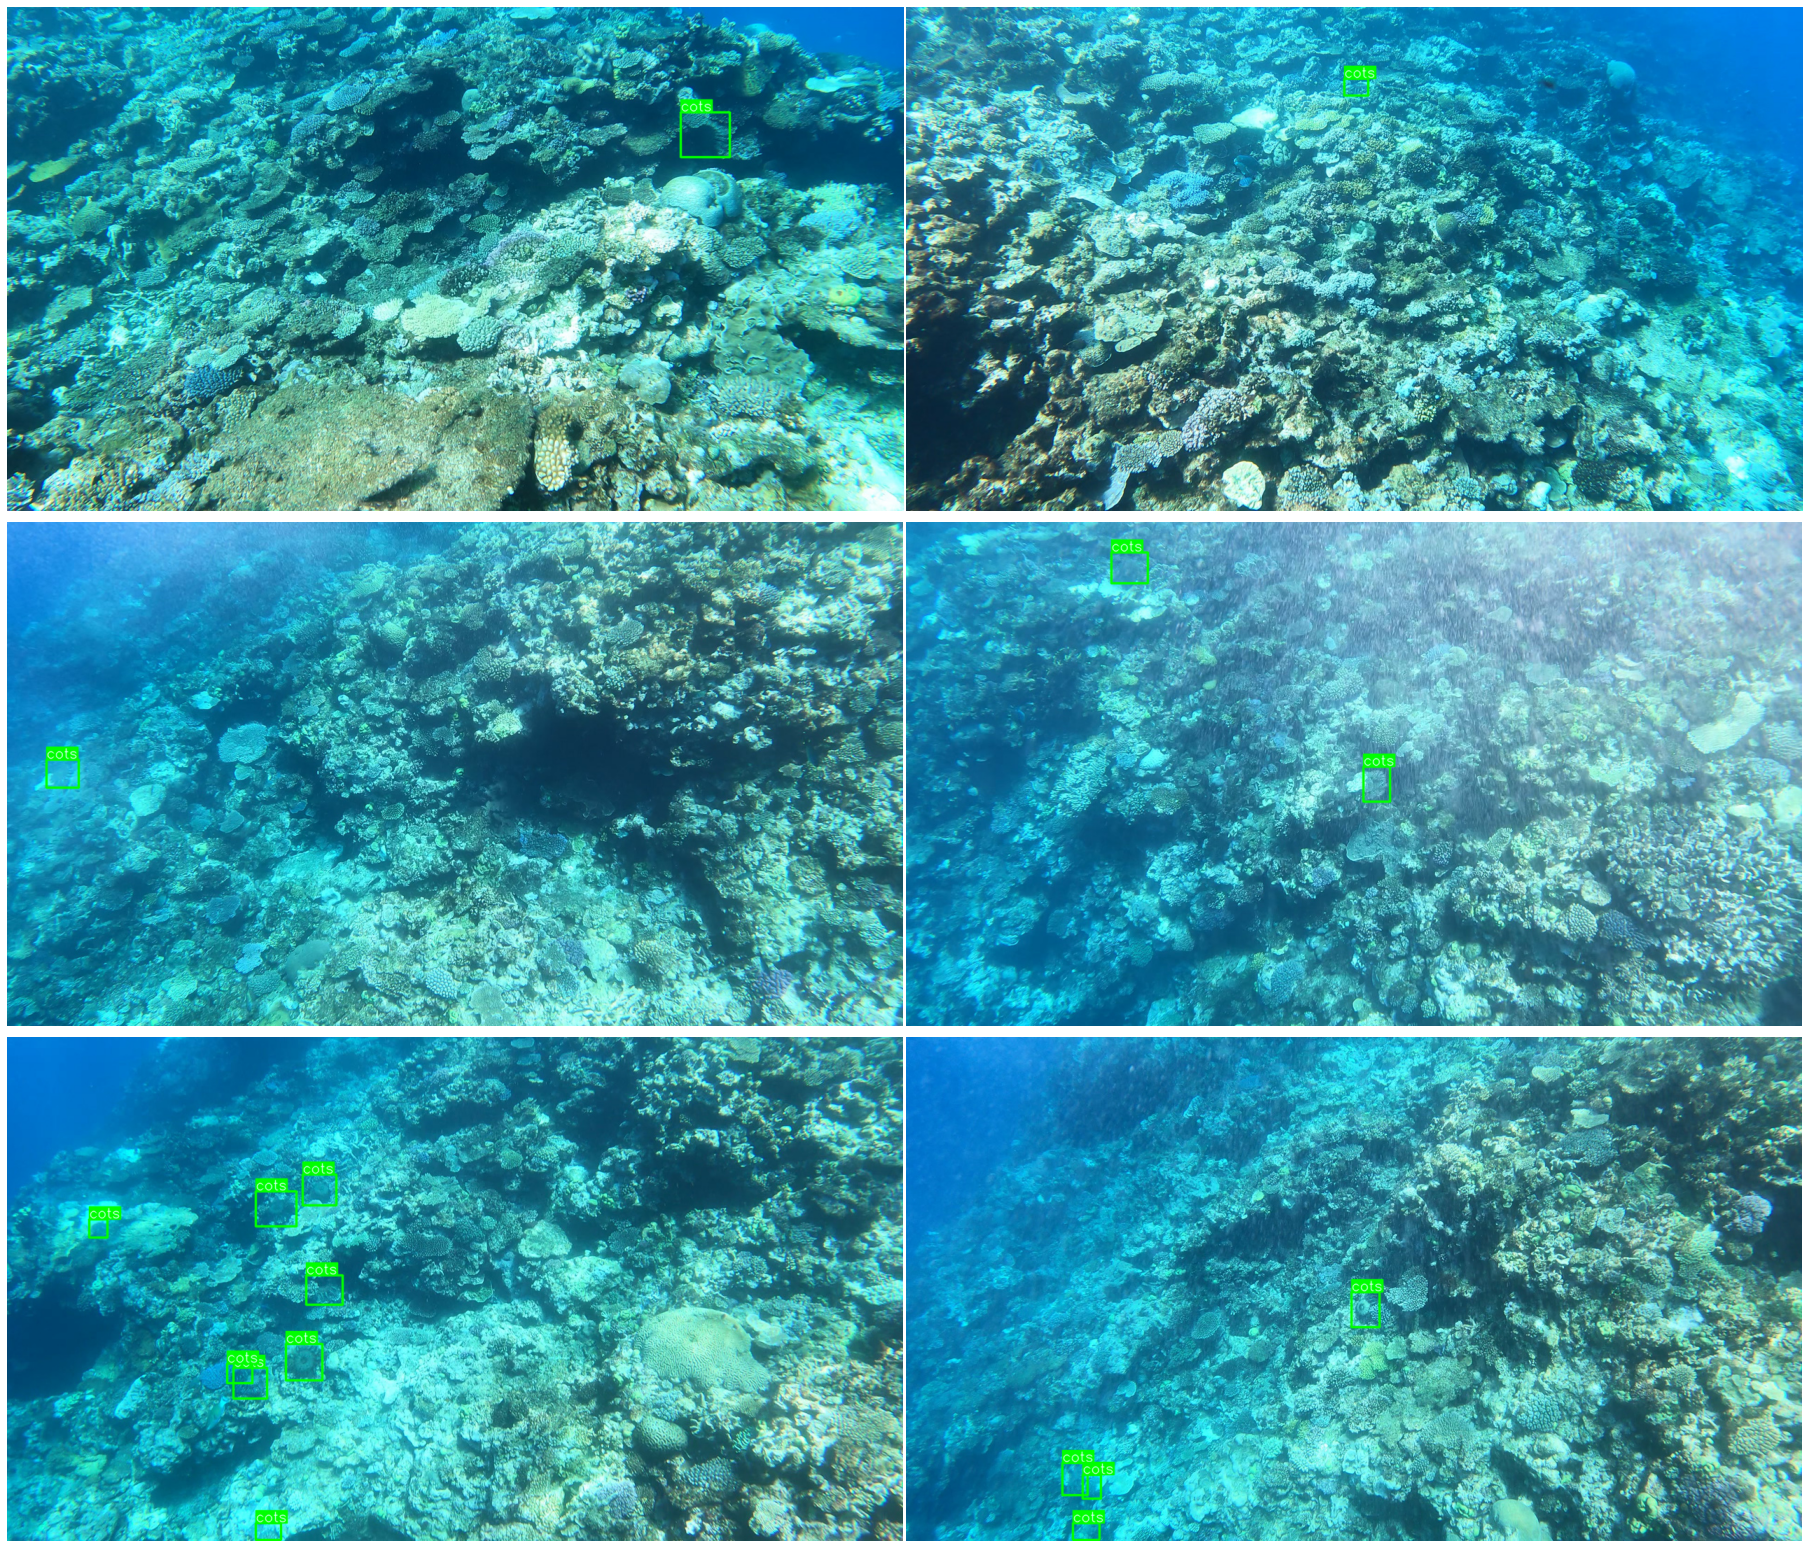

In [ ]:
df_visual = df_train[(df_train.num_bbox>0)].sample(100) 
y=3; x=2

plt.figure(figsize=(12.8*x, 7.2*y))
for i in range(x*y):
  row = df_visual.iloc[i]
  img = load_image(row.image_path)
  image_height = row.height
  image_width = row.width
  with open(row.label_path) as f:
    annot = str2annot(f.read())
  bboxes_yolo = annot[...,1:]
  labels = annot[...,0].astype(int).tolist()
  names = ['cots']*len(bboxes_yolo)
  plt.subplot(y, x, i+1)
  plt.imshow(draw_bboxes(img = img, bboxes=bboxes_yolo, classes=names, class_ids=labels, class_name=True, bbox_format='yolo', line_thickness=2))
  plt.axis('OFF')
plt.tight_layout()
plt.show()

### 3.3 Create YOLOv5 directory structure

I then organised the dataset on Google Drive using the YOLOv5 directory structure as follows:
      
      |--data 
      |    |--train
      |        |--images (*.jpg)
      |        |--labels (*.txt)
      |    |--valid
      |        |--images (*.jpg)
      |        |--labels (*.txt)

We need to split our images into training and validation datasets with their corresponding .txt files. We will use a split ratio of 80:20 - 80% training data and 20% validation data.

In [ ]:
TRAIN_IMAGES = '/content/drive/MyDrive/great_barrier_reef/train/images'
TRAIN_LABELS = '/content/drive/MyDrive/great_barrier_reef/train/labels'

VALID_IMAGES = '/content/drive/MyDrive/great_barrier_reef/valid/images'
VALID_LABELS = '/content/drive/MyDrive/great_barrier_reef/valid/labels'

In [ ]:
from sklearn.model_selection import GroupKFold

In [ ]:
## reset index in df_train before splitting into train and validation data

kf = GroupKFold(n_splits = 5) 
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, y = df_train.video_id.tolist(), groups=df_train.sequence)):
    df_train.loc[val_idx, 'fold'] = fold

df_train.head(5)

video_id  sequence  video_frame  ...  width height fold
0         0     40258           16  ...   1280    720    4
1         0     40258           17  ...   1280    720    4
2         0     40258           18  ...   1280    720    4
3         0     40258           19  ...   1280    720    4
4         0     40258           20  ...   1280    720    4

[5 rows x 13 columns]

### 3.4 Write training & validation files
Next, I copied the training and validation images and text files into the correct folders.

In [ ]:
from shutil import copyfile

In [ ]:
nfolds = 4

for i in tqdm(range(len(df_train))):
  row = df_train.loc[i]
  if row.fold != nfolds:
    copyfile(f'{row.image_path}', f'{TRAIN_IMAGES}/{row.image_id}.jpg')
    copyfile(f'{row.label_path}', f'{TRAIN_LABELS}/{row.image_id}.txt')
  else:
    copyfile(f'{row.image_path}', f'{VALID_IMAGES}/{row.image_id}.jpg')
    copyfile(f'{row.label_path}', f'{VALID_LABELS}/{row.image_id}.txt')

  0%|          | 0/4919 [00:00<?, ?it/s]

In [ ]:
print(f'Number of training files: {len(os.listdir(f"{TRAIN_IMAGES}"))}')
print(f'Number of validation files: {len(os.listdir(f"{VALID_IMAGES}"))}')

Number of training files: 3974
Number of validation files: 945


## 4. Define Model Configuration & Architecture

Next, we will write a model configuration file for the custom object detector. The smallest, fastest base model of YOLOv5. 
The dataset config file requires:

1. the dataset root directory path and relative paths to the `train`, `valid` data images (or .txt files with image paths)
2. The number of classes `nc` and;
3. A list of class names `['cots']`

###4.1 Clone YOLOv5 Repository & Install Dependencies
To start off with YOLOv5, we clone the YOLOv5 repository and install dependencies. This will set up our programming environment to be ready to run objection training and inference commands.

### 3.1 Write Model Architecture Configuration File
The model architecture file contains info about the no. of classes the dataset was trained on. Thus we will be creating the model architecture file directly using python and changint he 'nc' parameter to the no. of classes in our custom dataset.

The rest of the architecutre is hte same as the YOLOv5 S version.

Most importantly, the file also holds the value of pre-computed anchors (that helps us to detect objects) along with the architecture of the backbone and neck of our model. Other parameters like the structure of layers, no of layers, values of hyperparameters, and filteres are also defined in these files.

The export creates a YOLOv5.yaml file called `data.yaml` specifying the location of a YOLOv5 `images` folder, a YOLOv5 `labels` folder, and informtion on the custom classes.

In [ ]:
import yaml

### 3.2 Training Configuration File
Similar to the last section, we will now create a training configuration file. Like the name suggests, it provides the path to training and validation datasets. The 'train' and 'val' param provide the path to datasets while 'nc' represents the no. of clases and 'names' represents the class names associated with the class values (according to zero index).

In [ ]:
%cd /content/drive/MyDrive/great_barrier_reef
!git clone https://github.com/ultralytics/yolov5.git

/content/drive/MyDrive/great_barrier_reef


In [ ]:
%cd yolov5

/content/drive/MyDrive/great_barrier_reef/yolov5


In [ ]:
hyps = '''
# YOLOv5 by Ultralytics, GPL-3.0 license
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3) #####learning rate
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
anchors: 0  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction) #####aug
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction) #####aug
hsv_v: 0.4  # image HSV-Value augmentation (fraction) #####aug
degrees: 0.0  # image rotation (+/- deg).  #####aug
translate: 0.1  # image translation (+/- fraction).  #####aug
scale: 0.5  # image scale (+/- gain). #####aug
shear: 0.0  # image shear (+/- deg).  #####aug
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001 #####aug
flipud: 0.5  # image flip up-down (probability) #####aug
fliplr: 0.5  # image flip left-right (probability) #####aug
mosaic: 1.0  # image mosaic (probability) #####aug
mixup: 0.5  # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)
'''

In [ ]:
data = '''

train: /content/drive/MyDrive/great_barrier_reef/train/images  # train images
val: /content/drive/MyDrive/great_barrier_reef/valid/images  # val images 
test:  # test images (optional)

# Classes
nc: 1  # number of classes
names: ['cots']  # class names

'''

#### Write `data` and `hyps` files into `yolov5` folder

In [ ]:
with open('/content/drive/MyDrive/great_barrier_reef/yolov5/data/gbr_data.yaml', 'w') as fp:
    fp.write(data)
with open('/content/drive/MyDrive/great_barrier_reef/yolov5/data/hyps/gbr_hyps.yaml', 'w') as fp:
    fp.write(hyps)

##4. Train Our Custom Object Detector Model

With our `data.yaml` and `custom_yolov5s` yaml files ready to go we are ready to train.

Run the training command with the following otpions:


*   **img:** define input image size
*   **batch:** determine batch size (model weights are updated with each batch)
*   **epochs:** define the number of training epochs (often 3000+ is common)
*   **data:** set the path to yaml file (path to data configuration file)
*   **cfg:** specify model configuration (path to model architecture configuration file)
*   **weights**: specify custom path to weights (can download weights from the Ultralytics Google Drive folder)
* **name:** result names
* **nosave:** only save the final checkpoint
* **cache:** cache images for faster training

* Run Training *

During training, you want to be watching the mAP@0.5 to see how your detector is performing - see this post on breaking down mAP.









### Weights & Biases
Weights & Biases (W&B) is MLOPs platform for tracking our experiments. We can use it to build better models faster with experiment tracking, dataset versioning and model management. Soome of the cool features of W&B:
* Track, comapre and visualize ML experiments
* Get live metrics, terminal logs and system stats streamed to the centralised dashboard
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones

In [ ]:
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.7 MB 5.6 MB/s 
     |████████████████████████████████| 180 kB 55.8 MB/s 
     |████████████████████████████████| 143 kB 58.0 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="great-barrier-reef", entity="lara-sj")

wandb: Currently logged in as: lara-sj (use `wandb login --relogin` to force relogin)


### Training Command

We will start the training process by invoking the `train.py` file in the below code:

In [ ]:
FOLD = 1
DIM = 3000
MODEL = 'yolov5s'
BATCH = 4
EPOCHS = 10
OPTIMIZER = 'Adam'
NAME = f'{MODEL}-dim{DIM}-fold{FOLD}'
PROJECT   = 'great-barrier-reef'

In [ ]:
!pip install PyYAML==5.4.1
!python train.py --weights {MODEL} --img {DIM} --batch {BATCH} --epochs {EPOCHS} --cfg yolov5s.yaml --optimizer {OPTIMIZER} --data /content/drive/MyDrive/great_barrier_reef/yolov5/data/gbr_data.yaml --hyp /content/drive/MyDrive/great_barrier_reef/yolov5/data/hyps/gbr_hyps.yaml

     |████████████████████████████████| 636 kB 5.4 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


wandb: Currently logged in as: lara-sj (use `wandb login --relogin` to force relogin)
train: weights=yolov5s, cfg=yolov5s.yaml, data=/content/drive/MyDrive/great_barrier_reef/yolov5/data/gbr_data.yaml, hyp=/content/drive/MyDrive/great_barrier_reef/yolov5/data/hyps/gbr_hyps.yaml, epochs=10, batch_size=4, imgsz=3000, rect=False, resume=False, nosave=True, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-248-gcb2ad9f torch 1.10.0+cu111 CPU

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_

### Output Files

In [ ]:
OUTPUT_DIR = '{}/{}'.format(PROJECT, NAME)

In [ ]:
!ls {OUTPUT_DIR}

##5. Evaluate Model Performance

Look at the validation metrics to see how well the model has performed. The training script will drop the tensorboard logs in `runs`


In [ ]:
# start tensorboard
# launch after you run training
# logs save in the folder "runs"

# %load_ext tensorboard
# %tensorboard --logdir runs

If the above doesn't work the results can also be plotted with `utils.plot_results` and saving a `result.png`

We can also use some of the below:

In [ ]:
# from utils.utils import plot_results; plot_results() #plot results.txt as results png
# Image (filename='./results.png', width=1000) #view results.png

In [ ]:
# Image(filename='./test_batch0_gt.jpg', width=900) #view test image labels

##7. Run Inference on Test Image

Now we make inference on test images. After training has completed, model weights will save in `weights/`. For inference we invoke those weights along with a `conf` specifying model confidence (higher confidence required makes less predictions), and an inference `source`. `source` can accept a directory of images, indivudal images.

In [ ]:
# !python detect.py --weights weights/last_yolov5s_custom.pt --img 416 --conf 0.4 --source ../test_infer

## 8. Export Saved Weights for Future Inference

Now that our custom YOLOv5 object detector has been verified, we might want to take the weights out of Colab for use on a live computer vision task. To do so we import a Google Drive module and send them out.

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#%cp /content/yolov5/weights/last_yolov5s_custom.pt /content/gdrive/My\ Drive

In [2]:
!git init
!git config --global user.email lara.renae92@gmail.com
!git config --global user.name lara-sj

Reinitialized existing Git repository in /content/.git/


In [3]:
!git add -A

In [5]:
!git commit -m "commit first draft"

[master (root-commit) 5f6e2ea] commit first draft
 21 files changed, 50719 insertions(+)
 create mode 100644 .config/.feature_flags_config.yaml
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/.metricsUUID
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/gce
 create mode 100644 .config/logs/2022.02.18/14.32.33.591601.log
 create mode 100644 .config/logs/2022.02.18/14.32.54.268036.log
 create mode 100644 .config/logs/2022.02.18/14.33.12.888636.log
 create mode 100644 .config/logs/2022.02.18/14.33.21.113721.log
 create mode 100644 .config/logs/2022.02.18/14.33.40.493787.log
 create mode 100644 .config/logs/2022.02.18/14.33.41.267515.log
 create mode 100755 sample_data/README.md
 create mode 100755 sample_data/anscombe.json
 create m

In [6]:
!git remote add origin https://lara-sj@github.com/lara-sj/cots-detection-model.git

In [8]:
!git remote rm origin